In [0]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [0]:
!ls track

driving_log.csv  IMG


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Dense, Flatten
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [0]:
datadir = "track"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', None)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
print(data.iloc[1])

center      center_2018_07_16_17_11_43_670.jpg
left          left_2018_07_16_17_11_43_670.jpg
right        right_2018_07_16_17_11_43_670.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                                 0.627942
Name: 1, dtype: object


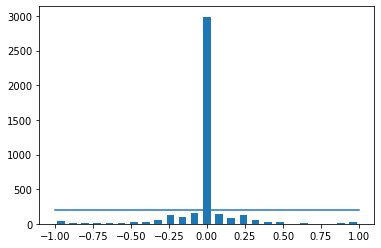

In [0]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

removed 2790
remaining 1263


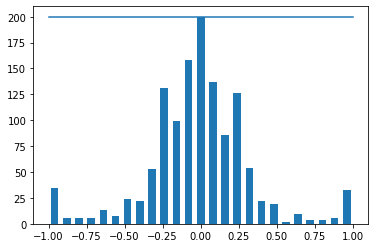

In [0]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))  

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, data):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training samples: {}\n Validation samples: {}'.format(len(X_train), len(X_val)))

Training samples: 1010
 Validation samples: 253


Text(0.5, 1.0, 'Validation set')

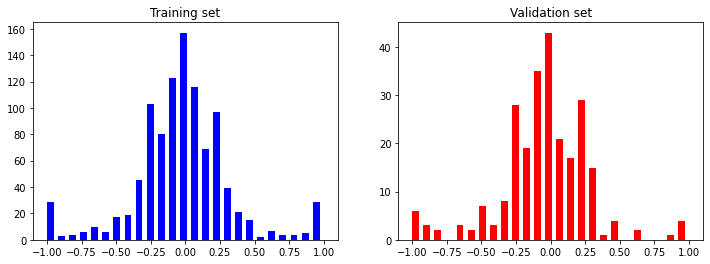

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_val, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Preprocessed Image')

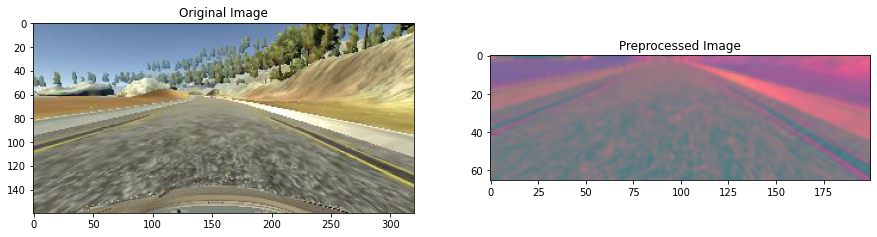

In [0]:
def image_preprocessing(img):
  img = mpimg.imread(img)
  img = img[60:137, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = image_preprocessing(image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
X_train = np.array(list(map(image_preprocessing, X_train)))
X_val = np.array(list(map(image_preprocessing, X_val)))

(1010, 66, 200, 3)


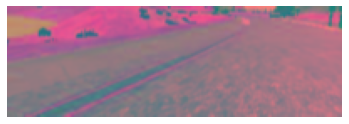

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))

  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  
  model.compile(Adam(lr=0.001), loss='mse')
  return model

In [0]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [0]:
h = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=100, verbose=1, shuffle=1)

Train on 1010 samples, validate on 253 samples
Epoch 1/30
1010/1010 [==============================] - 1s 663us/step - loss: 96.4773 - val_loss: 0.1397
Epoch 2/30
1010/1010 [==============================] - 0s 301us/step - loss: 4.6615 - val_loss: 0.1272
Epoch 3/30
1010/1010 [==============================] - 0s 301us/step - loss: 3.3420 - val_loss: 0.1484
Epoch 4/30
1010/1010 [==============================] - 0s 298us/step - loss: 2.7198 - val_loss: 0.1173
Epoch 5/30
1010/1010 [==============================] - 0s 294us/step - loss: 1.9859 - val_loss: 0.1059
Epoch 6/30
1010/1010 [==============================] - 0s 287us/step - loss: 2.2599 - val_loss: 0.6836
Epoch 7/30
1010/1010 [==============================] - 0s 295us/step - loss: 3.4468 - val_loss: 0.1094
Epoch 8/30
1010/1010 [==============================] - 0s 300us/step - loss: 2.8050 - val_loss: 0.1066
Epoch 9/30
1010/1010 [==============================] - 0s 293us/step - loss: 2.6524 - val_loss: 0.1301
Epoch 10/30
1010

Text(0.5, 0, 'Epochs')

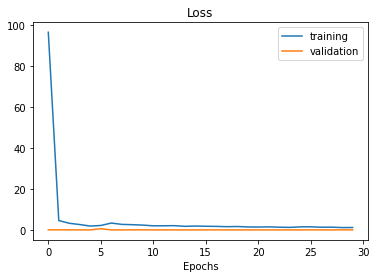

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')


In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')

In [42]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# model.save('model.h5')
# model_file = drive.CreateFile({'title' : 'model.h5'})
# model_file.SetContentFile('model.h5')
# model_file.Upload()
# drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1960H16PpQaoBNW2plTPRJNjX52z40OxD'})